# Setup

In [1]:
from utils import *

# Compute travel times

In [2]:
centroids = pd.read_parquet('data/centroids.parquet').disp()

143,971 rows x 5 cols; Memory: 24.4 MiB


,geoid,level,city,x,y
,<object>,<object>,<object>,<float32>,<float32>
0,42007,county,pittsburgh,-80.349266,40.682495


## OSRM
**OSRM**: Open-Source Routing Machine

Set up a server for each combination of city and mode using [osrm_server.sh](osrm_server.sh). Once the server hits up and running, run [get_ttm_osrm.py](get_ttm_osrm.py) to extract travel times and write the data to disk. This is a 2-step manual and time-consuming process.

## R5
Directly extract travel times using [get_ttm_r5.py](get_ttm_r5.py) that uses the R5py package (working properly in the `r5` conda environment). For times by public transit, GTFS data zip files are needed.

### Runtimes
| City              | Transit (MBP) | Walk (MBP)    | Bike (U5)     | Drive (U5)    |
| -                 | -:            | -:            | -:            | -:            |
| Atlanta           | 4:06          | 3:51          | 28:53         |               |
| Austin            |               | 1:38          | ?             | 1:21:13       |
| Baltimore         |               | 2:41          | ?             | 2:41:37       |
| Boston            |               | 5:48          | ?             | 9:23:34       |
| Bridgeport        |               | 0:41          | ?             | 0:34:45       |
| Buffalo           |               | 0:47          | ?             | 0:21:19       |
| Charlotte         |               | 1:14          | ?             | 1:53:17       |
| Chicago           |               | 13:14         | ?             |               |
| Cincinnati        |               | 0:56          | ?             |               |
| Cleveland         |               | 1:19          | ?             |               |
| Columbus          |               | 1:05          | ?             |               |
| Dallas            |               | 4:21          | ?             |               |
| Denver            |               | 3:47          | ?             |               |
| Detroit           |               | 3:47          | ?             |               |
| Hartford          |               | 0:45          | ?             |               |
| Houston           |               | 3:38          | ?             |               |
| Indianapolis      |               | 1:25          | 15:20         |               |
| Jacksonville      |               | 0:38          | 5:48          |               |
| Kansas City       |               | 1:39          | ?             |               |
| Las Vegas         |               | 1:21          | ?             |               |
| Los Angeles       | 19:08         | 18:06         | 2:22:16       |               |
| Louisville        |               | 0:35          | ?             | 1:28          |
| Memphis           |               | 0:36          | ?             | 36:03         |
| Miami             | 5:30          | 7:12          | 58:38         |               |
| Milwaukee         |               | 2:35          | ?             | 1:36:24       |
| Minneapolis       |               | 3:22          | ?             | 6:14:31       |
| Nashville         | 0:44          | 0:42          | 4:34          |               |
| New York          |               | 49:49         | ?             |               |
| Oklahoma City     |               | 0:40          | ?             | 47:38         |
| Orlando           | 1:00          | 0:54          | 8:17          |               |
| Philadelphia      |               | 5:25          | ?             |               |
| Phoenix           | 5:43          | 4:00          | 46:49         |               |
| Pittsburgh        |               | 1:13          | ?             | 2:53:15       |
| Portland          | 2:42          | 2:02          | 20:39         |               |
| Providence        |               | 0:54          | ?             | 1:05:54       |
| Raleigh           | 1:02          | 0:54          | 6:56          |               |
| Richmond          |               | 0:46          | ?             | 45:33         |
| Riverside         | 1:33          | 1:33          | 8:37          |               |
| Sacramento        | 1:24          | 1:15          | 12:10         |               |
| Salt Lake City    | 1:12          | 1:02          | 13:09         |               |
| San Antonio       | 1:15          | 0:50          | 6:40          |               |
| San Diego         | 2:15          | 1:53          | 14:45         |               |
| San Francisco     |               | 3:37          | ?             | 5:09:55       |
| San Jose          | 2:25          | 2:11          | 25:04         |               |
| Seattle           | 11:11         | 4:22          | 47:03         |               |
| St. Louis         |               | 1:21          | ?             | 3:20:40       |
| Tampa             |               | N/A           | 16:41         | 2:44:14       |
| Tucson            | 1:01          | 0:54          | 9:11          |               |
| Virginia Beach    |               | 0:49          | 5:23          | 53:29         |
| Washington        | 8:18          | 7:06          | 1:10:46       |               |
| **Total**         | **2:18:23**   | **3:01:13**   | **9:27:39**   |               |

# Analysis

## OSRM vs R5

In [3]:
zones = gpd.read_parquet('data/zones.parquet', filters=[
    ('city', '==', 'Austin'), ('level', '==', 'BG')],
                         columns=['geoid', 'geometry'])

In [4]:
def compare_osrm_r5(city, mode):
    r5 = pd.read_parquet(glob(f'data/ttm/r5/{city}_{mode}*')[0])
    r5 = filt(r5, level='BG').rename(columns=D(time='r5'))
    osrm = pd.read_parquet(f'data/ttm/osrm/{city}_{mode}_bg.parquet',
                           columns=['src', 'trg', 'time'])
    osrm['osrm'] = osrm.pop('time') / 60
    tt = r5.merge(osrm, on=('src', 'trg'))
    tt['ratio'] = tt.osrm / tt.r5
    return tt

city = 'austin'
wa = compare_osrm_r5(city, 'walk').disp()
dr = compare_osrm_r5(city, 'drive')
bi = compare_osrm_r5(city, 'bike')

74,636 rows x 5 cols; Memory: 9.4 MiB


,src,trg,r5,osrm,ratio
,<object>,<object>,<int16>,<float32>,<float32>
0,484530400004,484530400004,0,0.0,NaN


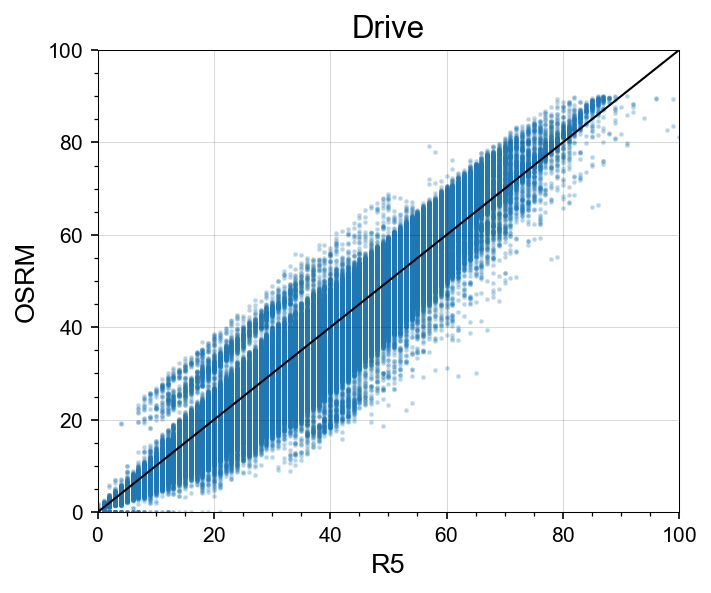

In [5]:
ax = plot(size=(5, 4), dpi=150, xlab='R5', ylab='OSRM',
          xlim=(0, 100), ylim=(0, 100), title='Drive')
ax.scatter(dr.r5, dr.osrm, s=2, alpha=0.2)
ax.plot(*[[0, 100]] * 2, color='k', lw=1);

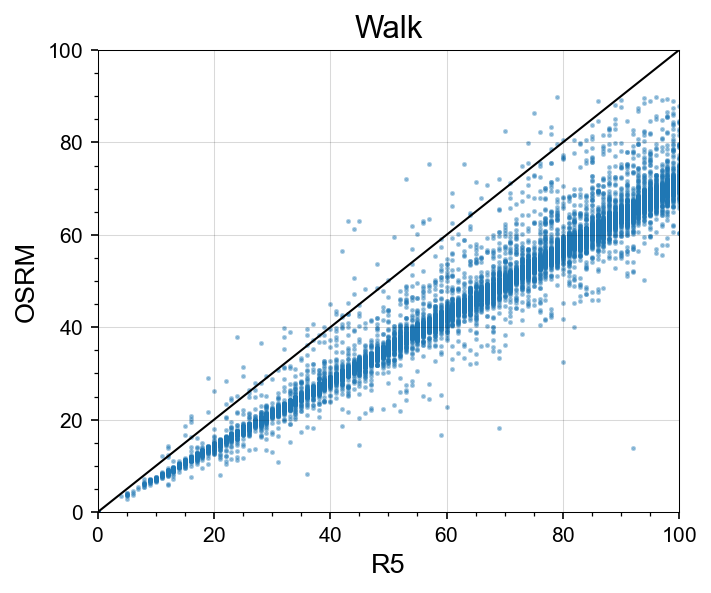

In [6]:
ax = plot(size=(5, 4), dpi=150, xlab='R5', ylab='OSRM',
          xlim=(0, 100), ylim=(0, 100), title='Walk')
ax.scatter(wa.r5, wa.osrm, s=2, alpha=0.2)
ax.plot(*[[0, 100]] * 2, color='k', lw=1);

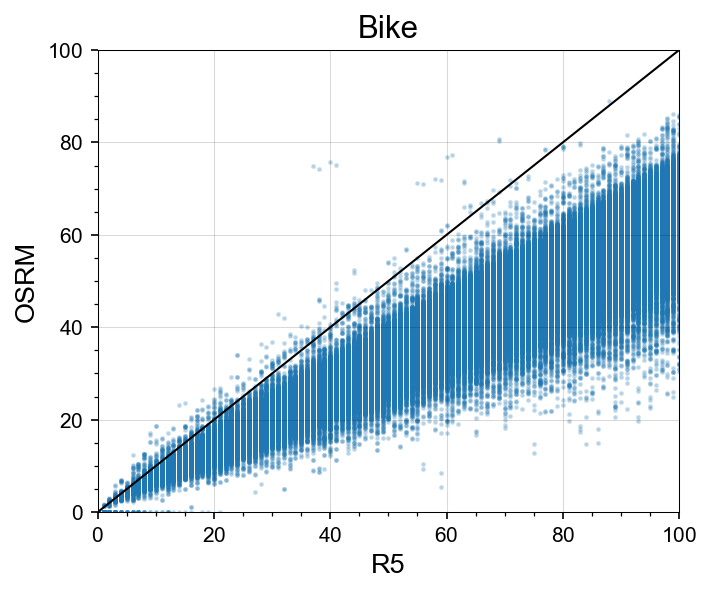

In [7]:
ax = plot(size=(5, 4), dpi=150, xlab='R5', ylab='OSRM',
          xlim=(0, 100), ylim=(0, 100), title='Bike')
ax.scatter(bi.r5, bi.osrm, s=2, alpha=0.2)
ax.plot(*[[0, 100]] * 2, color='k', lw=1);

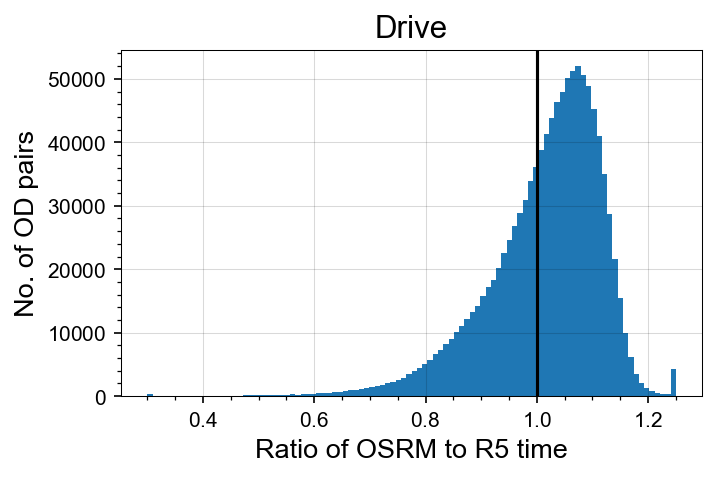

In [8]:
ax = plot(size=(5, 3), title='Drive',
          xlab='Ratio of OSRM to R5 time', ylab='No. of OD pairs')
dr.ratio.clip(0.3, 1.25).hist(bins=100, ax=ax)
ax.axvline(1, color='k');

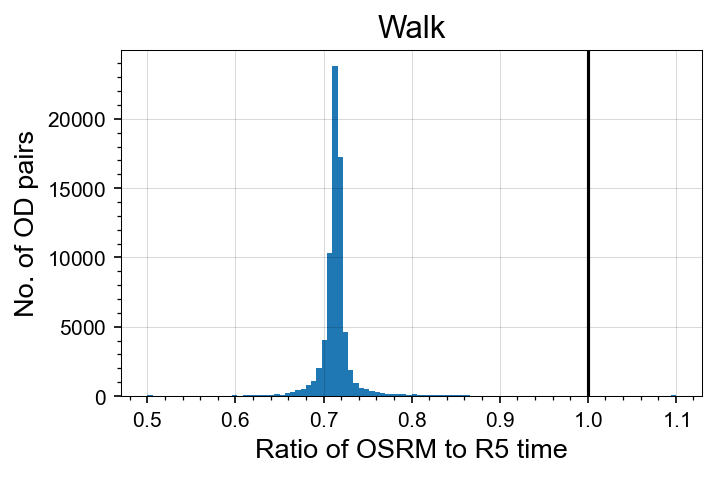

In [9]:
ax = plot(size=(5, 3), title='Walk',
          xlab='Ratio of OSRM to R5 time', ylab='No. of OD pairs')
wa.ratio.clip(0.5, 1.1).hist(bins=100, ax=ax)
ax.axvline(1, color='k');

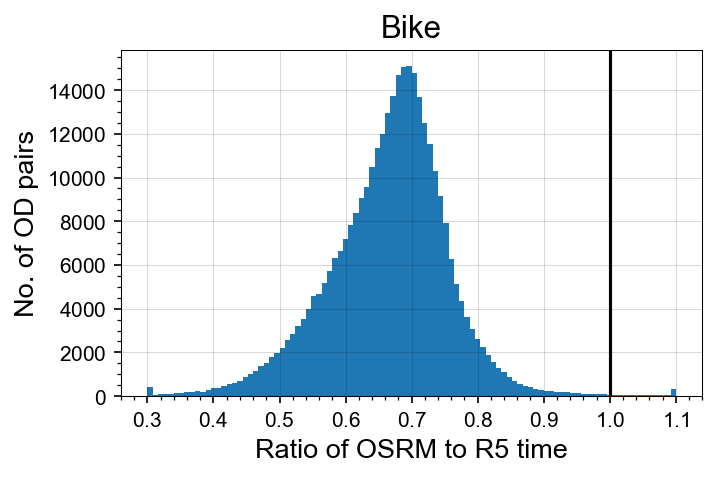

In [10]:
ax = plot(size=(5, 3), title='Bike',
          xlab='Ratio of OSRM to R5 time', ylab='No. of OD pairs')
bi.ratio.clip(0.3, 1.1).hist(bins=100, ax=ax)
ax.axvline(1, color='k');

In [3]:
all_ = {f.split('/')[-1].split('_')[0] for f in glob('data/ttm/osrm/*')}
done = {f.split('/')[-1].split('_')[0] for f in glob('data/ttm/r5/*drive*')}
all_ - done

{'birmingham',
 'chicago',
 'cleveland',
 'columbus',
 'dallas',
 'denver',
 'detroit',
 'fresno',
 'grand-rapids',
 'houston',
 'jacksonville',
 'kansas-city',
 'las-vegas',
 'new-york',
 'philadelphia'}

In [11]:
xsOs = filt(pd.read_parquet('data/access_long/austin.parquet'),
            measure='Contour', kind='Jobs: All', mode='Drive',
            thresh='30', level='BG')
xsOs = zones.merge(xsOs).disp()

1,048 rows x 3 cols; Memory: 0.1 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,geometry,access
,<object>,<geometry>,<float32>
0,484530400004,"POLYGON ((-97.712407 30.347856, -97.712357 30....",950029.0


In [ ]:
xsOs = filt(pd.read_parquet('data/access_long/austin.parquet'),
            measure='Contour', kind='Jobs: All', mode='Drive',
            thresh='30', level='BG')
xsOs = zones.merge(xsOs).disp()

1,048 rows x 3 cols; Memory: 0.1 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,geometry,access
,<object>,<geometry>,<float32>
0,484530400004,"POLYGON ((-97.712407 30.347856, -97.712357 30....",950029.0


In [12]:
aaa = (pd.read_parquet('data/aaa/2022/Texas-drive-block_group.parquet')
       .astype(D(geoid=str)).query('thresh==30'))
aaa = zones.merge(aaa, on='geoid').disp()

1,051 rows x 4 cols; Memory: 0.1 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,geometry,thresh,access
,<object>,<geometry>,<int64>,<float32>
0,484530400004,"POLYGON ((-97.712407 30.347856, -97.712357 30....",30,970206.625


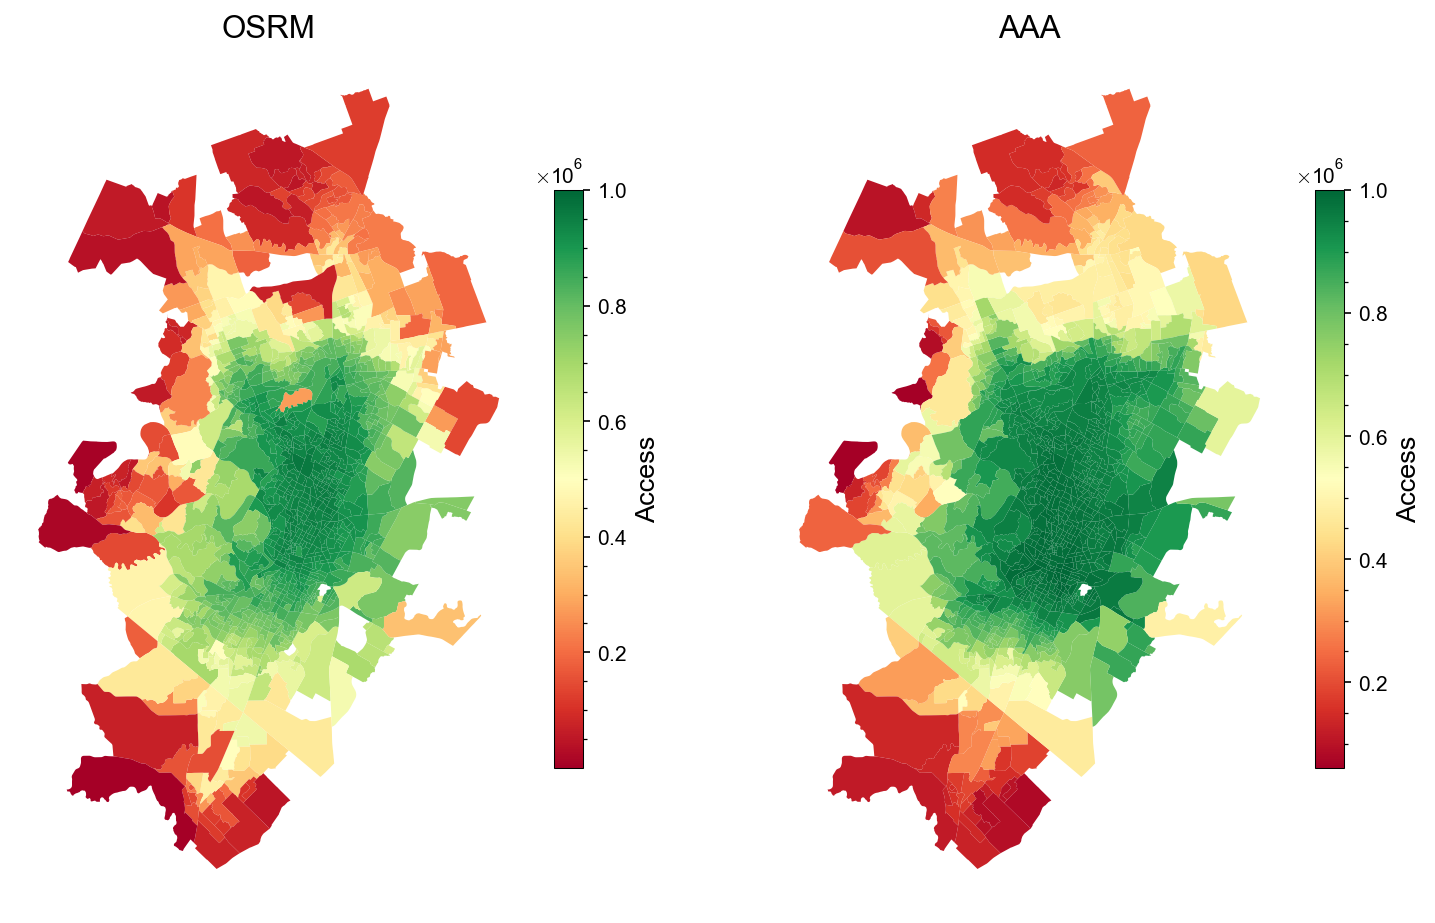

In [13]:
_, axes = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
for i, (df, label) in enumerate([(xsOs, 'OSRM'), (aaa, 'AAA')]):
    ax = plot(axes[i], title=label, axoff=1)
    maplot(df, 'access', ax=ax, cmap='RdYlGn',
           bgmap=None, label='Access', vmax=1e6)